In [1]:
import numpy as np 
# import tensorflow as tf
import os 
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import time

# Implementing RCNN

### First try : 

<ul>
    <li>Instead, we solve the CNN localization problem by operating within the “recognition using regions” paradigm </li>
    <li>At test time, our method generates around 2000 category-independent region proposals for
the input image, extracts a fixed-length feature vector from
each proposal using a CNN, and then classifies each region
with category-specific linear SVMs</li>
</ul>

<ul>
    <li>Our object detection system consists of three modules.</li>
    <li>The first generates category-independent region proposals</li>
    <li> The second module is a large convolutional neural network that extracts a fixed-length feature
vector from each region</li>
    <li>The third module is a set of classspecific linear SVMs</li>

</ul>

### Region proposal :  

<ul>
    <li></li>
    
</ul>

### Feature extraction

<ul>
    <li>Features are computed by forward propagating
a mean-subtracted 227 × 227 RGB image through five convolutional layers and two fully connected layers</li>
    <li>In order to compute features for a region proposal, we
must first convert the image data in that region into a form
that is compatible with the CNN (its architecture requires
        inputs of a fixed 227 × 227 pixel size)</li>
    <li>we warp all pixels in a tight bounding box
        around it to the required size</li>
    <li>Regardless of the size or aspect ratio of the
candidate region, we warp all pixels in a tight bounding box
around it to the required size. Prior to warping, we dilate the
tight bounding box so that at the warped size there are exactly p pixels of warped image context around the original
box</li>
</ul>

### Test-time detection

<ul>
    <li>At test time, we run selective search on the test image
to extract around 2000 region proposals</li>
    <li>Then, for each class, we score
each extracted feature vector using the SVM trained for that
class</li>
    <li>Given all scored regions in an image, we apply a
greedy non-maximum suppression (for each class independently) that rejects a region if it has an intersection-overunion (IoU) overlap with a higher scoring selected region
        larger than a learned threshold</li>
</ul>

### Training 

<ul>
    <li>We start SGD at
a learning rate of 0.001 (1/10th of the initial pre-training
rate), which allows fine-tuning to make progress while not
clobbering the initialization. In each SGD iteration, we uniformly sample 32 positive windows (over all classes) and
96 background windows to construct a mini-batch of size
128. We bias the sampling towards positive windows because they are extremely rare compared to background.</li>
    
</ul>

### Let's try to see the impact of selective search

In [2]:
def convert_to_xywh(x1,y1,x2,y2): 
    '''
        convert a corner type bbox to a xyhw bbox
    '''
    
    x = (x1 + x2) / 2
    y = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    
    return x,y,w,h

In [3]:
img_size = (500, 300)

In [8]:
curr_path = os.getcwd() 
data_path = os.path.join(curr_path, "data")
training_path = os.path.join(data_path, "training") 
labels_path = os.path.join(training_path, "label_2") 
images_path = os.path.join(training_path, "image_2")

images = []
labels = []

target_labels = ["Car", "Pedestrian", "Truck", "Van", "Person_sitting", "Cyclist", "Tram", "Misc", "DontCare"]

for i, img_path in enumerate(os.listdir(images_path)[:10]): 
    # get img
    full_label = []
    img = cv2.imread(os.path.join(images_path, img_path)) 
#     x_ratio = img_size[1] / img.shape[0]
#     y_ratio = img_size[0] / img.shape[1]
#     print(x_ratio, y_ratio)
#     img = cv2.resize(img, img_size)
    images.append(img)
    
    # get label 
    label_path = os.listdir(labels_path)[i]

    with open(os.path.join(labels_path, label_path), "r") as f: 
        lines = f.readlines()
        for line in lines:
            
            lab = "".join(line).replace("\n", "").split(" ")
            lab = [np.float32(x) if lab.index(x) != 0 else target_labels.index(x) for x in lab]
            # scale bbox 
#             left, top, right, bottom = lab[4:8]
#             print("pre" ,[left, top, right, bottom])
#             left = left * x_ratio 
#             top = top * y_ratio 
#             right = right * x_ratio 
#             bottom = bottom * y_ratio
#             lab[4:8] = [left, top, right, bottom]
#             print("post", [left, top, right, bottom])
            full_label.append(lab)
        labels.append(full_label)

In [9]:
image = images[0] 
bbox = labels[0][0][4:8] 
bbox

[712.4, 143.0, 810.73, 307.92]

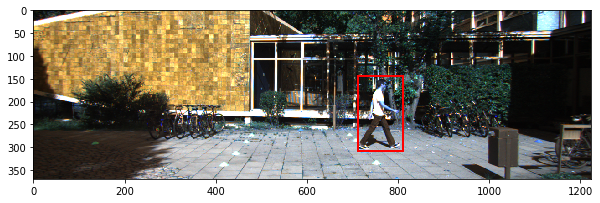

In [10]:
plt.figure(figsize=(10,10))
ax = plt.gca()
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.imshow(image)

In [56]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(images[2])
ss.switchToSelectiveSearchFast()
start = time.time()
rects = ss.process()
end = time.time()
print(f"Detected region proposals in {end - start}")

Detected region proposals in 4.977121591567993


### displaying the region proposal made by the Selective Search algorithm

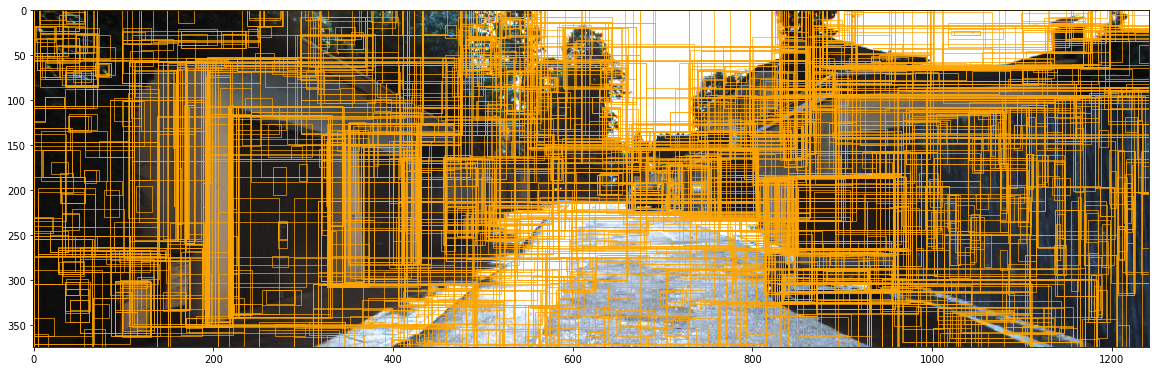

In [59]:
plt.figure(figsize=(20,20))
ax = plt.gca()
for x,y,w,h in rects[:2000]: 
    rect = patches.Rectangle((x, y), w, h, linewidth=0.7, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
plt.imshow(images[2])